In [1]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

In [2]:
# Import the three provided datasets (adjust filepaths)
df_listings = pd.read_csv('/content/drive/MyDrive/Datasets/Exam_Assignment/listings2024.csv')
df_calendar = pd.read_csv('/content/drive/MyDrive/Datasets/Exam_Assignment/calendar2024.csv')
df_reviews = pd.read_csv('/content/drive/MyDrive/Datasets/Exam_Assignment/reviews2024.csv')

In [3]:
# Change data types for calculations
df_listings['price'] = df_listings['price'].str.replace('$', '', regex=False) \
                                     .str.replace(',', '', regex=False) \
                                     .astype(float)
df_calendar['price'] = df_calendar['price'].str.replace('$', '', regex=False) \
                                     .str.replace(',', '', regex=False) \
                                     .astype(float)
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

In [4]:
# Replace the neighborhood names
name_mapping = {
    'Nrrebro': 'Nørrebro',
    'Vesterbro-Kongens Enghave': 'Vesterbro',
    'Indre By': 'Indre By',
    'sterbro': 'Østerbro',
    'Frederiksberg': 'Frederiksberg',
    'Amager Vest': 'Amager Vest',
    'Amager st': 'Amager Øst',
    'Bispebjerg': 'Bispebjerg',
    'Valby': 'Valby',
    'Vanlse': 'Vanløse',
    'Brnshj-Husum': 'Brønshøj-Husum'
}

df_listings['neighbourhood_cleansed'] = df_listings['neighbourhood_cleansed'].replace(name_mapping)
df_listings.rename(columns = {'neighbourhood_cleansed':'neighborhood_cleansed', 'id' : 'listing_id'}, inplace = True)

In [5]:
# Drop listings without price data as well as outliers in all three datasets
df_listings.dropna(subset = ['price'], inplace = True)
iqr = df_listings['price'].quantile(0.75) - df_listings['price'].quantile(0.25)
upper_quantile = df_listings['price'].quantile(0.75)
lower_quantile = df_listings['price'].quantile(0.25)
df_listings = df_listings[(df_listings['price'] > lower_quantile - 8 * iqr) &
                          (df_listings['price'] < upper_quantile + 8 * iqr)]
remaining_ids = df_listings['listing_id']
df_calendar = df_calendar[df_calendar['listing_id'].isin(remaining_ids)]
df_reviews = df_reviews[df_reviews['listing_id'].isin(remaining_ids)]

In [6]:
# Replace boolean values by numeric values in df_calendar to facilitate calculations
df_calendar['available'] = df_calendar['available'].replace({'f' : 1, 't' : 0})

<ipython-input-6-c54d3fd76436>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_calendar['available'] = df_calendar['available'].replace({'f' : 1, 't' : 0})


In [7]:
# Create column with the average occupancy of the listing
occupancy_listings = df_calendar.groupby('listing_id')['available'].mean().reset_index()
occupancy_listings['available'] = occupancy_listings['available'] * 100
df_listings = df_listings.merge(occupancy_listings, on = 'listing_id')
df_listings.rename(columns = {'available' : 'occupancy_next_365'}, inplace = True)

In [8]:
# Parse listings
df_listings['amenities_parsed'] = df_listings['amenities'].apply(lambda x: json.loads(x) if pd.notnull(x) else [])

In [9]:
# Standardize amenities
def clean_amenity(amenity):
  """
  This function iterates through every amenity and replaces it with a standardized string using regular expressions.
  """
  amenity = re.sub(r'[\[\]{}"\'\d]', '', amenity)
  amenity = amenity.strip().lower()
  if re.search(r'\bfast\b', amenity) and re.search(r'\bwifi\b', amenity):
    return 'Fast wifi'
  if re.search(r'\bwi[\s\-]?fi\b', amenity) or re.search(r'\binternet\b', amenity) or re.search(r'\bethernet\b', amenity) and not re.search(r'\bfast\b', amenity):
    return 'Wifi or ethernet'
  if re.search(r'\btv\b', amenity):
    return 'TV'
  if re.search(r'\bdisney+\b', amenity) or re.search(r'\bdisney plus\b', amenity):
    return 'Disney+'
  if re.search(r'\bnetflix\b', amenity):
    return 'Netflix'
  if re.search(r'\bprime\b', amenity) and re.search(r'\bvideo\b', amenity):
    return 'Amazon Prime Video'
  if re.search(r'\bapple[\s\-]?tv\b', amenity):
    return 'AppleTV'
  if re.search(r'\bhdtv\b', amenity):
    return 'HD TV'
  if re.search(r'\bconditioner\b', amenity):
    return 'Conditioner'
  if re.search(r'\bshampoo\b', amenity):
    return 'Shampoo'
  if re.search(r'\bshower gel\b', amenity):
    return 'Shower gel'
  if re.search(r'\bsoap\b', amenity):
    return 'Soap'
  if re.search(r'\bbidet\b', amenity):
    return 'Bidet'
  if re.search(r'\bps5\b', amenity) or re.search(r'\bps4\b', amenity) or re.search(r'\bconsole\b', amenity):
    return 'Game console'
  if re.search(r'\brefrigerator\b', amenity):
    return 'Refrigerator'
  if re.search(r'\bpool\b', amenity) or re.search(r'\bhot[\s\-]?tub\b', amenity):
    return 'Pool'
  if re.search(r'\boven\b', amenity):
    return 'Oven'
  if re.search(r'\bfurniture\b', amenity) and re.search(r'\boutdoor\b', amenity):
    return 'Outdoor furniture'
  if re.search(r'\bstove\b', amenity):
    return 'Stove'
  if re.search(r'\btreadmill\b', amenity):
    return 'Treadmill'
  if re.search(r'\bexercise equipment\b', amenity):
    return 'Exercise equipment'
  if re.search(r'\bgym\b', amenity):
    return 'Gym'
  if re.search(r'\bdrying rack\b', amenity):
    return 'Drying rack'
  if re.search(r'\bsound\b', amenity) and re.search(r'\bsystem\b', amenity):
    return 'Sound system'
  if re.search(r'\boutdoor\b', amenity) and re.search(r'\bshower\b', amenity):
    return 'Outdoor shower'
  if re.search(r'\bhousekeeping\b', amenity) or re.search(r'\bcleaning\b', amenity):
    return 'Housekeeping'
  if re.search(r'\bcoffee\b', amenity):
    return 'Coffee machine'
  if re.search(r'\bespresso\b', amenity):
    return 'Espresso machine'
  if re.search(r'\bward[\s\-]?\b', amenity) or re.search(r'\bclothing storage:?\b', amenity):
    return 'Wardrobe'
  if re.search(r'\bcloset\b', amenity):
    return 'Closet'
  if re.search(r'\bbooks\b', amenity):
    return 'Books'
  if re.search(r'\btoys\b', amenity):
    return 'Toys'
  if re.search(r'\bev\b', amenity) and re.search(r'\bcharger\b', amenity):
    return 'Electronic vehicle charger'
  if re.search(r'\bparking\b', amenity):
    return 'Parking'
  if re.search(r'\bcarport\b', amenity):
    return 'Carport'
  if re.search(r'\bgarage\b', amenity):
    return 'Garage'
  if re.search(r'\bbbq\b', amenity) or re.search(r'\bgrill\b', amenity) or re.search(r'\bbarbecue\b', amenity):
    return 'BBQ grill'
  if re.search(r'\bwasher\b', amenity) or re.search(r'\blaundry\b', amenity):
    return 'Washing machine'
  if re.search(r'\bbackyard\b', amenity):
    return 'Backyard'
  if re.search(r'\bview\b', amenity) and not 'courtyard' in amenity:
    return 'Scenic view'
  if re.search(r'\bfire[\s\-]?place\b', amenity) or re.search(r'\bfire pit\b', amenity):
    return 'Fire place'
  if re.search(r'\bbaby\b', amenity) or re.search(r'\bhigh[\s\-]?chair\b', amenity) or re.search(r'\bcrib\b', amenity) or re.search(r'\bchanging table\b', amenity):
    return 'Baby utensils'
  if re.search(r'\bbabysitter recommendations\b', amenity):
    return 'Babysitter options'
  if re.search(r'\btable corner guards\b', amenity) or re.search(r'\boutlet covers\b', amenity):
    return 'Toddler protection measures'
  if re.search(r'\bdryer\b', amenity) and not re.search(r'\bhair\b', amenity):
    return 'Dryer'
  if re.search(r'\bdryer\b', amenity) and re.search(r'\bhair\b', amenity):
    return 'Hair dryer'
  if re.search(r'\bsauna\b', amenity):
    return 'Sauna'
  if re.search(r'\bbalcony\b', amenity):
    return 'Balcony'
  if re.search(r'\bpatio\b', amenity):
    return 'Patio'
  if re.search(r'\bheating\b', amenity) or re.search(r'\bheater\b', amenity):
    return 'Heating or portable heater'
  if re.search(r'\bair[\s\-]?conditioning\b', amenity) or re.search(r'\bac\b', amenity):
    return 'Air conditioning'
  if re.search(r'\bfans?\b', amenity):
    return 'Fan'
  if re.search(r'\bski\b', amenity):
    return 'Ski lift access'
  if re.search(r'\baccess\b', amenity) and re.search(r'\bbeach\b', amenity):
    return 'Beach access'
  if re.search(r'\bresort\b', amenity) and re.search(r'\baccess\b', amenity):
    return 'Resort access'
  if re.search(r'\blife size games\b', amenity) or re.search(r'\bboard games\b', amenity) or re.search(r'\barcade games\b', amenity):
    return 'Games'
  if re.search(r'\bcarbon\b', amenity) and re.search(r'\balarm\b', amenity):
    return 'Carbon monoxide/dioxide alarm'
  if re.search(r'\bsmoke alarm\b', amenity):
    return 'Smoke alarm'
  if re.search(r'\boutdoor kitchen\b', amenity):
    return 'Outdoor kitchen'
  else:
    return amenity.capitalize()

df_listings['cleaned_amenities'] = df_listings['amenities_parsed'].apply(lambda x: list(set(clean_amenity(amenity) for amenity in x)))

In [10]:
# Create a new dataframe containing each amenity listing combination
amenity_table = []
for idx, row in df_listings.iterrows():
  listing_id = row['listing_id']
  amenities = row['cleaned_amenities']
  for amenity in amenities:
    amenity_table.append({'listing_id': listing_id, 'amenity': amenity})

df_listings_amenities = pd.DataFrame(amenity_table)

<Axes: >

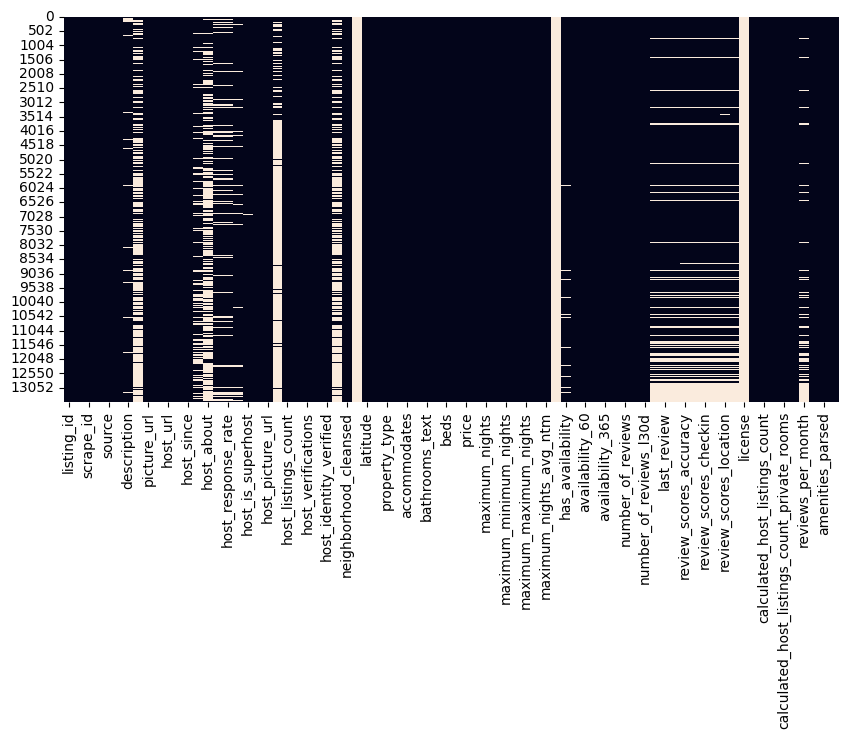

In [11]:
# Figure 1
plt.figure(figsize=(10,5))
sns.heatmap(df_listings.isnull(), cbar=False)

<ipython-input-12-9bfdbe1725bf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_bedrooms['bin_bedrooms'] = pd.cut(df_listings_bedrooms['bedrooms'], bins = bins, labels = labels, include_lowest = True, right = False)
<ipython-input-12-9bfdbe1725bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_types['room_type'] = df_listings_types['room_type'].replace({'Entire home/apt':'Entire home'})


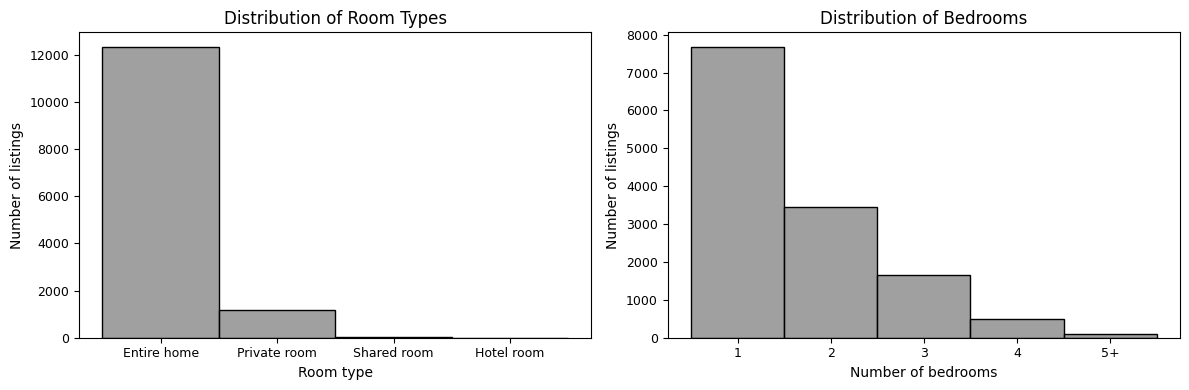

In [12]:
# Figure 2
df_listings_bedrooms = df_listings[['listing_id', 'bedrooms']]
bins = [1, 2, 3, 4, 5, float('inf')]
labels = ['1', '2', '3', '4', '5+']
df_listings_bedrooms['bin_bedrooms'] = pd.cut(df_listings_bedrooms['bedrooms'], bins = bins, labels = labels, include_lowest = True, right = False)
df_listings_types = df_listings[['listing_id', 'room_type']]
df_listings_types['room_type'] = df_listings_types['room_type'].replace({'Entire home/apt':'Entire home'})

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = df_listings_bedrooms, x = 'bin_bedrooms', color = 'gray', ax = axes[1])
axes[1].set_xlabel('Number of bedrooms', fontsize = 10)
axes[1].tick_params(axis = 'x', labelsize = 9)
axes[1].set_ylabel('Number of listings')
axes[1].set_title('Distribution of Bedrooms')
axes[1].tick_params(axis = 'y', labelsize = 9)

sns.histplot(data = df_listings_types, x = 'room_type', color = 'gray', ax = axes[0])
axes[0].set_xlabel('Room type')
axes[0].set_ylabel('Number of listings')
axes[0].set_title('Distribution of Room Types')
axes[0].tick_params(axis = 'x', labelsize = 9)
axes[0].tick_params(axis = 'y', labelsize = 9)
plt.savefig('distribution_plots.png', dpi = 300, bbox_inches = 'tight')
fig.tight_layout()
plt.show()

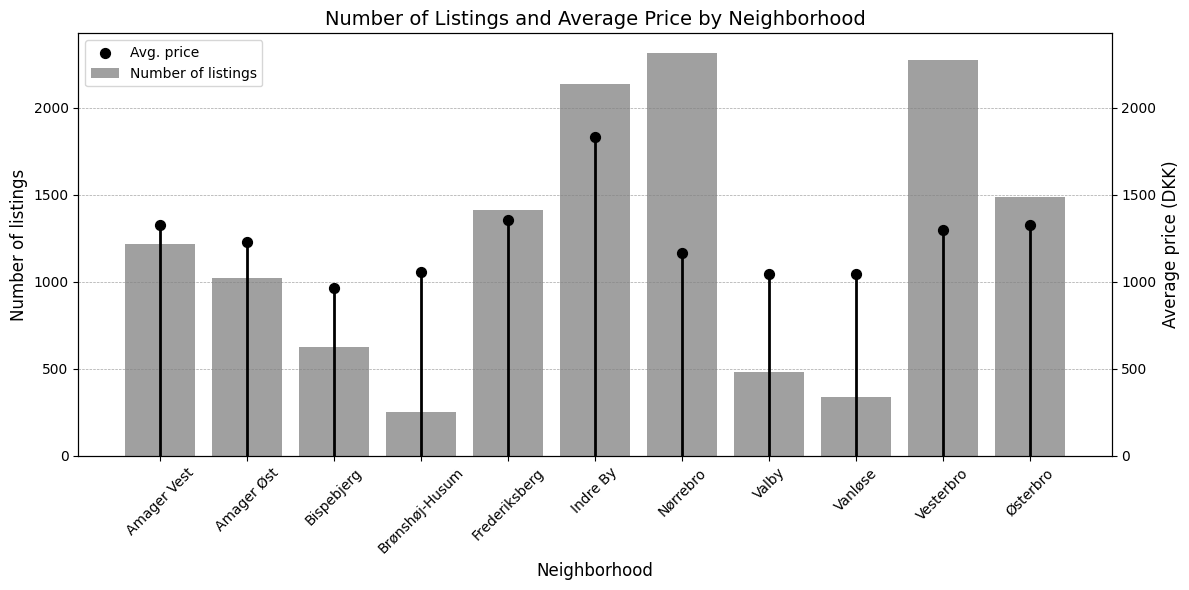

In [13]:
# Figure 3
df_neighborhood_price = df_listings.groupby('neighborhood_cleansed').agg(number = ('listing_id', 'count'), avg_price = ('price', 'mean')).reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
sns.barplot(data = df_neighborhood_price, x='neighborhood_cleansed', y='number', color='#a0a0a0', ax=ax, label='Number of listings')

for i, row in df_neighborhood_price.iterrows():
    ax.plot([i, i], [0, row['avg_price']], color='black', linewidth=2)
    ax.scatter(i, row['avg_price'], color='black', s=50, label='Avg. price' if i == 0 else "")

ax.set_xticks(range(len(df_neighborhood_price)))
ax.set_xticklabels(df_neighborhood_price['neighborhood_cleansed'], rotation=45)
ax.set_xlabel('Neighborhood', fontsize=12)
ax.set_ylabel('Number of listings', fontsize=12)
ax.set_title('Number of Listings and Average Price by Neighborhood', fontsize=14)

ax2 = ax.twinx()
ax2.set_ylabel('Average price (DKK)', fontsize=12)
ax2.set_ylim(ax.get_ylim())

ax.legend(loc='upper left', fontsize=10, title_fontsize=11, frameon=True)

plt.tight_layout()
plt.savefig('geographical_distribution_avg_price.png', dpi = 300, bbox_inches = 'tight')
plt.show()

<ipython-input-14-ff4b7b8a710d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_melted, x = 'Metric', y = 'Score', palette = 'gray')


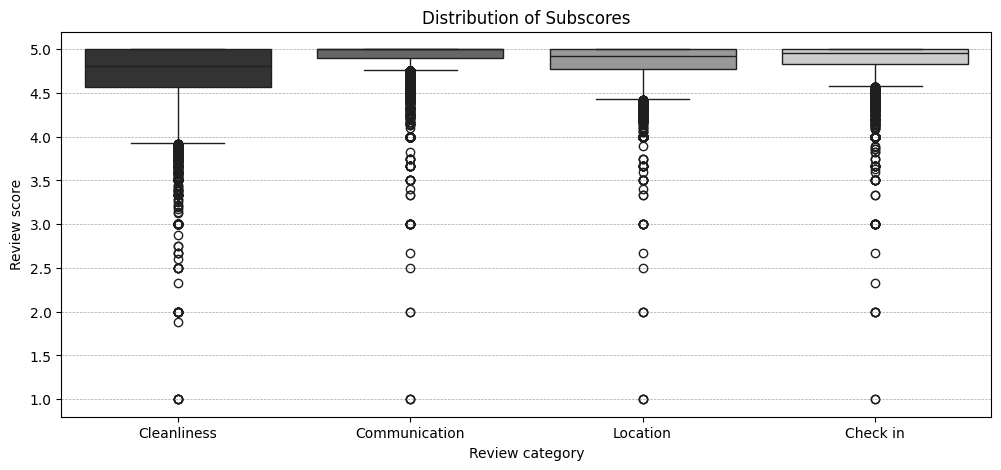

In [14]:
# Figure 4
columns = ['review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_checkin']
df_melted = df_listings[columns].melt(var_name = 'Metric', value_name = 'Score')

plt.figure(figsize = (12, 5))
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
sns.boxplot(data = df_melted, x = 'Metric', y = 'Score', palette = 'gray')
plt.title('Distribution of Subscores')
plt.xlabel('Review category')
plt.ylabel('Review score')
plt.xticks(ticks = [0, 1, 2, 3], labels = ['Cleanliness', 'Communication', 'Location', 'Check in'])
plt.savefig('distribution_subscores.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
# Create dataframes with the average occupancy and the average price per day in the observation period
occupancy = df_calendar.groupby('date')['available'].mean()
df_occupancy = pd.DataFrame(occupancy)
df_occupancy = df_occupancy.rename(columns = {'date': 'date', 'available': 'occupancy'}).reset_index()
df_occupancy['occupancy'] = df_occupancy['occupancy'] * 100
df_occupancy.head()

df_prices = df_calendar.groupby('date')['price'].mean().reset_index()

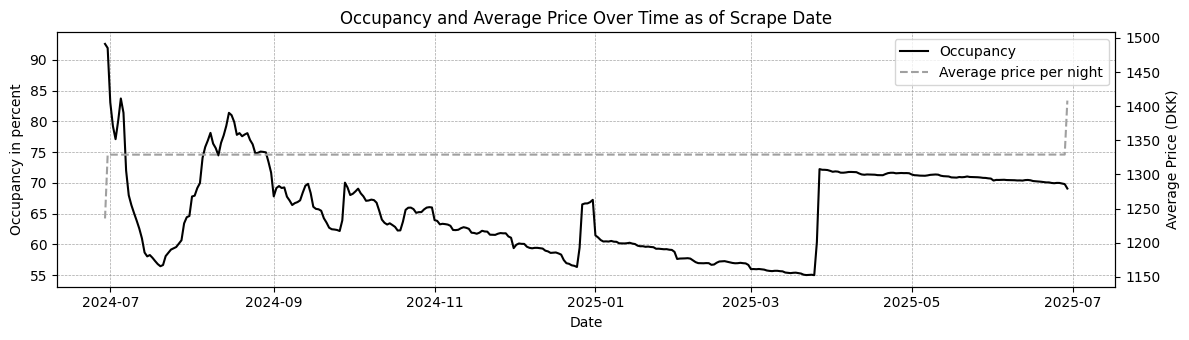

In [16]:
# Figure 5
fig, ax1 = plt.subplots(figsize=(12, 3.5))
ax1.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
line1, = ax1.plot(df_occupancy['date'], df_occupancy['occupancy'], color='black', label='Occupancy')
ax1.set_ylabel('Occupancy in percent')
ax1.set_xlabel('Date')
ax2 = ax1.twinx()
line2, = ax2.plot(df_prices['date'], df_prices['price'], color='#a0a0a0', linestyle='--', label='Average price per night')
ax2.set_ylabel('Average Price (DKK)')
ax2.set_ylim(df_prices['price'].min() - 100, df_prices['price'].max() + 100)
plt.title('Occupancy and Average Price Over Time as of Scrape Date')
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')
fig.tight_layout()
plt.savefig('occupancy_price.png', dpi = 300, bbox_inches = 'tight')
plt.show()

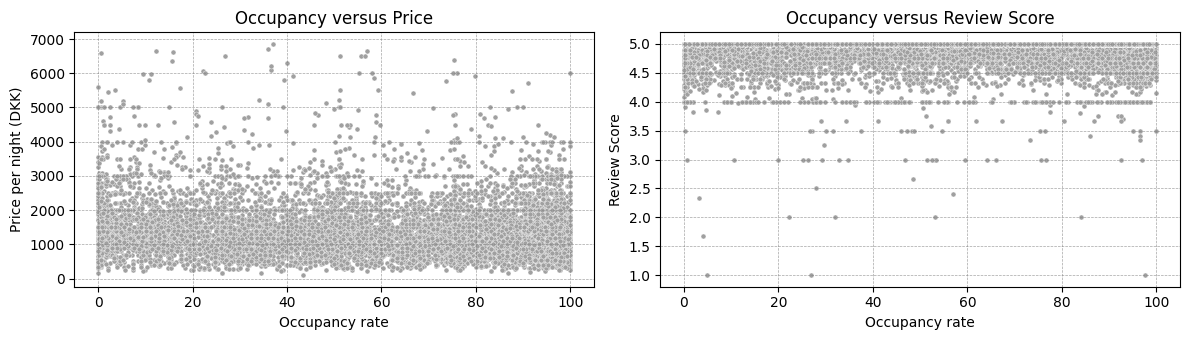

In [17]:
# Figure 6
fig, axes = plt.subplots(1, 2, figsize = (12,3.5))
for ax in axes:
  ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
sns.scatterplot(data = df_listings, x = 'occupancy_next_365', y = 'price', ax = axes[0], color = '#a0a0a0', s = 13)
sns.scatterplot(data = df_listings, x = 'occupancy_next_365', y = 'review_scores_rating', ax = axes[1], color = '#a0a0a0', s = 13)
axes[0].set_title('Occupancy versus Price')
axes[0].set_xlabel('Occupancy rate')
axes[0].set_ylabel('Price per night (DKK)')
axes[1].set_title('Occupancy versus Review Score')
axes[1].set_xlabel('Occupancy rate')
axes[1].set_ylabel('Review Score')

fig.tight_layout()
plt.savefig('occupancy_vs_price_vs_reviews.png', dpi = 300, bbox_inches = 'tight')
plt.show()

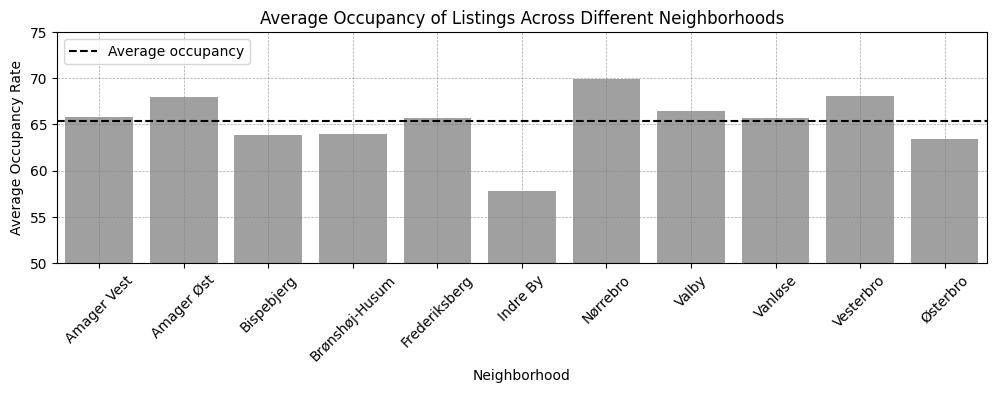

In [18]:
# Figure 7
df_geo = df_listings.groupby('neighborhood_cleansed')['occupancy_next_365'].mean().reset_index(name = 'avg_occupancy')

avg = df_geo['avg_occupancy'].mean()
fig, ax = plt.subplots(figsize = (12, 3))
sns.barplot(data = df_geo, x = 'neighborhood_cleansed', y = 'avg_occupancy', color = '#a0a0a0', ax = ax)
line = ax.axhline(y = avg, color = 'black', linestyle = '--', linewidth = 1.5, label = f'Average occupancy')
ax.set_title('Average Occupancy of Listings Across Different Neighborhoods')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Average Occupancy Rate')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylim(50, 75)
ax.legend(loc = 'upper left')
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.savefig('occupancy_neighborhoods.png', dpi = 300, bbox_inches = 'tight')
plt.show()

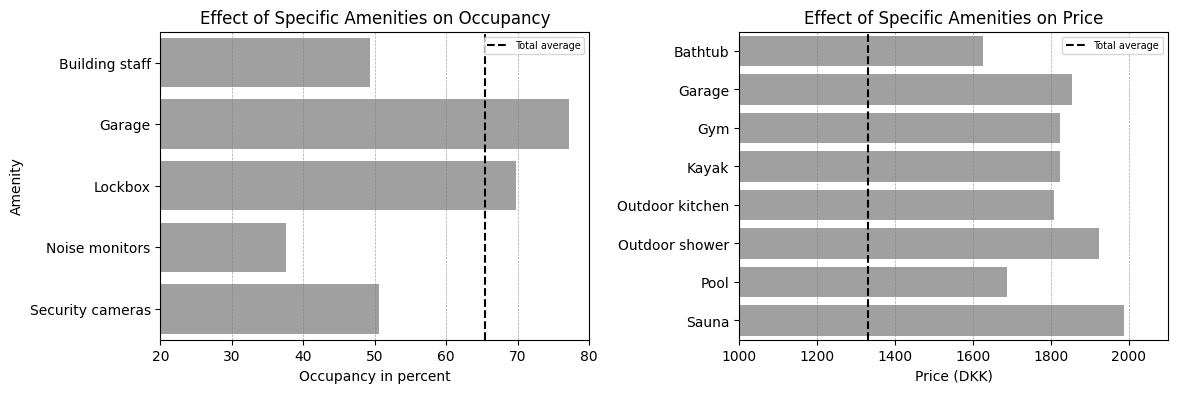

In [19]:
# Figure 8
df_merged = df_listings_amenities.merge(df_listings[['listing_id', 'price', 'occupancy_next_365']], on = 'listing_id')
df_merged['amenity'] = df_merged['amenity'].replace({'Exterior security cameras on property': 'Security cameras', 'Noise decibel monitors on property':'Noise monitors', "Children's playroom": 'Playroom'})
df_merged_price = df_listings_amenities.merge(df_listings[['listing_id', 'price']])
amenities_price = ['Bathtub', 'Garage', 'Gym', 'Kayak', 'Outdoor kitchen', 'Outdoor shower', 'Pool', 'Sauna']
amenities_occupancy = ['Building staff', 'Security cameras', 'Noise monitors', 'Lockbox', 'Garage', 'Playroom']
df_merged_filtered_price = df_merged[df_merged['amenity'].isin(amenities_price)]
df_merged_filtered_price_agg = df_merged_filtered_price.groupby('amenity')['price'].mean().reset_index()
df_merged_filtered_occupancy = df_merged[df_merged['amenity'].isin(amenities_occupancy)]
df_merged_filtered_occupancy_agg = df_merged_filtered_occupancy.groupby('amenity')['occupancy_next_365'].mean().reset_index()

avg_price = df_listings['price'].mean()
avg_occupancy = df_listings['occupancy_next_365'].mean()

fig, ax = plt.subplots(1, 2, figsize = (13,4))
plt.subplots_adjust(wspace = 0.35)
for single_ax in ax:
  single_ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
sns.barplot(data = df_merged_filtered_occupancy_agg, y = 'amenity', x = 'occupancy_next_365', color = '#a0a0a0', ax = ax[0])
sns.barplot(data = df_merged_filtered_price_agg, y = 'amenity', x = 'price', color = '#a0a0a0', ax = ax[1])
ax[1].set_ylabel('')
ax[0].set_xlim(20, 80)
ax[1].set_xlim(1000, 2100)
ax[0].set_title('Effect of Specific Amenities on Occupancy')
ax[1].set_title('Effect of Specific Amenities on Price')
ax[0].set_xlabel('Occupancy in percent')
ax[0].set_ylabel('Amenity')
ax[1].set_xlabel('Price (DKK)')
ax[0].axvline(avg_occupancy, color='black', linestyle='--', linewidth=1.5, label=f'Total average')
ax[1].axvline(avg_price, color='black', linestyle='--', linewidth=1.5, label=f'Total average')
ax[1].legend(loc='upper right', fontsize = 7)
ax[0].legend(loc='upper right', fontsize = 7)
plt.savefig('amenity_occuancy_price.png', dpi = 300, bbox_inches = 'tight')

<ipython-input-20-c3d81dfa13b0>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_profile_pic, x='host_has_profile_pic', y='occupancy_next_365', ax=axes[1], palette='Grays')
<ipython-input-20-c3d81dfa13b0>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_superhost, x='host_is_superhost', y='occupancy_next_365', ax=axes[2], palette='Grays')


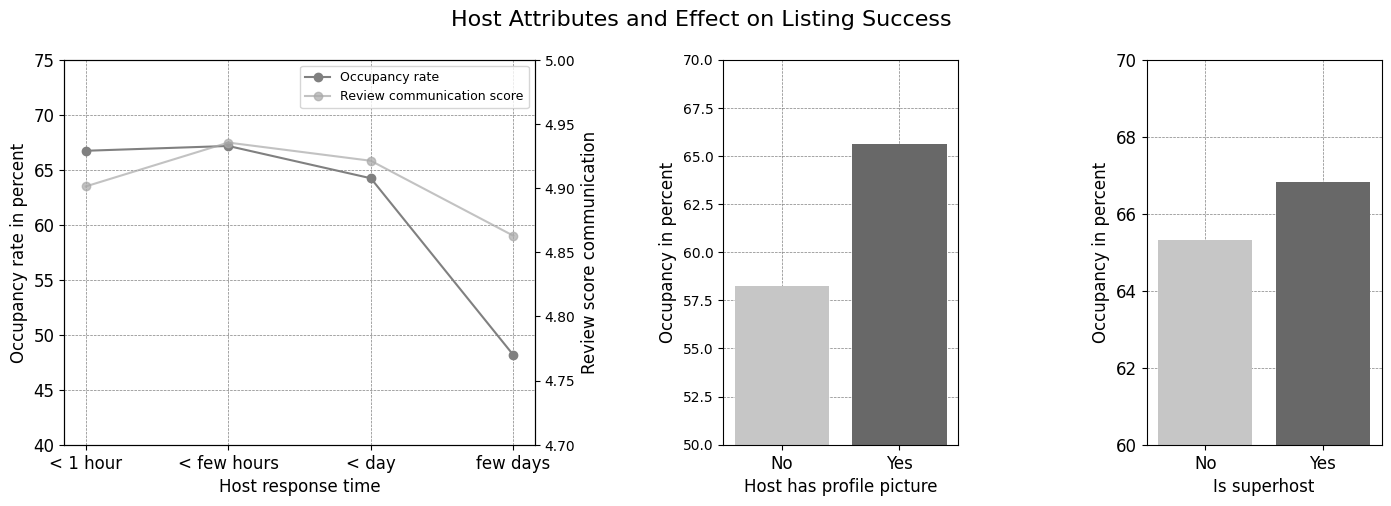

In [20]:
# Figure 9
df_response_time = df_listings.groupby('host_response_time').agg({
    'occupancy_next_365': 'mean',
    'review_scores_communication': 'mean'
}).reset_index()

df_profile_pic = df_listings.groupby('host_has_profile_pic').agg({'occupancy_next_365':'mean'}).reset_index()
df_profile_pic['host_has_profile_pic'] = df_profile_pic['host_has_profile_pic'].replace({'t':'Yes', 'f':'No'})

df_superhost = df_listings.groupby('host_is_superhost').agg({'occupancy_next_365':'mean'}).reset_index()
df_superhost['host_is_superhost'] = df_superhost['host_is_superhost'].replace({'t':'Yes', 'f':'No'})

order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

df_response_time['host_response_time'] = pd.Categorical(df_response_time['host_response_time'], categories=order, ordered=True)
df_response_time = df_response_time.sort_values('host_response_time')

fig, axes = plt.subplots(1, 3, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1, 1]})

ax1 = axes[0]
x = np.arange(len(order))

ax1.plot(x, df_response_time['occupancy_next_365'], marker='o', color='gray', label='Occupancy Rate')
ax1.set_ylabel('Occupancy rate in percent', fontsize = 12)
ax1.set_xlabel('Host response time', fontsize = 12)
ax1.set_xticks(x)
ax1.set_xticklabels(['< 1 hour', '< few hours', '< day', 'few days'])  # Neue Beschriftungen
ax1.set_ylim(40, 75)
ax1.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
ax1.set_axisbelow(True)

ax2 = ax1.twinx()
ax2.plot(x, df_response_time['review_scores_communication'], marker='o', color='darkgray', label='Review Communication Score', alpha=0.7)
ax2.set_ylabel('Review score communication', fontsize = 12)
ax2.set_ylim(4.7, 5)
ax2.grid(False)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=10)

lines = ax1.get_lines() + ax2.get_lines()
labels = ['Occupancy rate', 'Review communication score']
ax1.legend(lines, labels, loc='upper right', frameon=True, fontsize=9)

sns.barplot(data=df_profile_pic, x='host_has_profile_pic', y='occupancy_next_365', ax=axes[1], palette='Grays')
axes[1].set_xlabel('Host has profile picture', fontsize = 12)
axes[1].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
axes[1].set_axisbelow(True)
axes[1].set_ylim(50, 70)
axes[1].set_ylabel('Occupancy in percent', fontsize = 12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=10)

sns.barplot(data=df_superhost, x='host_is_superhost', y='occupancy_next_365', ax=axes[2], palette='Grays')
axes[2].set_xlabel('Is superhost', fontsize = 12)
axes[2].grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
axes[2].set_axisbelow(True)
axes[2].set_ylim(60, 70)
axes[2].set_ylabel('Occupancy in percent', fontsize = 12)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)

plt.subplots_adjust(wspace=0.6)

fig.suptitle('Host Attributes and Effect on Listing Success', fontsize=16)
plt.savefig('host_attributes_smaller.png', dpi = 300)
plt.show()

In [21]:
# Create date_neighborhood_occupancy dataframe
df_calendar['neighborhood'] = df_calendar['listing_id'].map(df_listings.set_index('listing_id')['neighborhood_cleansed'])
df_occupancy_neighborhood = df_calendar.groupby(['date', 'neighborhood']).agg(avg_occupancy = ('available', 'mean')).reset_index()
df_occupancy_neighborhood = df_occupancy_neighborhood['avg_occupancy'] * 100

In [22]:
# Extract host informations
df_host_information = df_listings[['host_id', 'host_response_time', 'host_is_superhost', 'host_has_profile_pic']]

In [23]:
# Create dataframe with neighborhood coordinates
df_neighborhood_coordinates = df_listings.groupby('neighborhood_cleansed')[['longitude', 'latitude']].mean()

In [24]:
# Select necessary columns from the listings dataframe for the dashboard
df_listings = df_listings[['listing_id', 'neighborhood_cleansed', 'host_id', 'listing_url', 'last_scraped', 'name', 'property_type', 'room_type', 'accommodates',
                          'price', 'review_scores_rating', 'number_of_reviews', 'occupancy_next_365']]

In [25]:
# Select necessary columns from the calendar dataframe for the dashboard
df_calendar = df_calendar[['listing_id', 'date', 'available', 'price']]

In [26]:
# Export the seven dataframes
df_listings.to_csv('listings.csv', index = False)
df_calendar.to_csv('calendar.csv', index = False)
df_listings_amenities.to_csv('amenities.csv', index = False)
df_host_information.to_csv('host_information.csv', index = False)
df_neighborhood_coordinates.to_csv('neighborhood_coordinates.csv', index = False)
df_occupancy_neighborhood.to_csv('date_occupancy_neighborhood.csv', index = False)
df_prices.to_csv('date_prices.csv', index = False)